Assignment 2 

Image processing


L.S.Lankagama

190350F

Question 3(a)

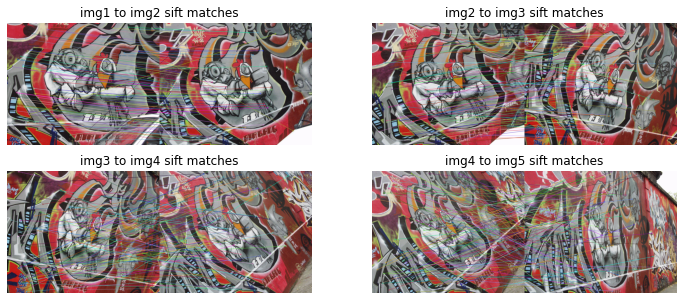

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread("img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread("img2.ppm", cv.IMREAD_COLOR)
img3 = cv.imread("img3.ppm", cv.IMREAD_COLOR)
img4 = cv.imread("img4.ppm", cv.IMREAD_COLOR)
img5 = cv.imread("img5.ppm", cv.IMREAD_COLOR)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create(nfeatures=0,nOctaveLayers=3,contrastThreshold=0.04,edgeThreshold=10,sigma=1.6)

kp1, descriptors_1 = sift.detectAndCompute(img1, None) 
kp2, descriptors_2 = sift.detectAndCompute(img2, None)
kp3, descriptors_3 = sift.detectAndCompute(img3, None)
kp4, descriptors_4 = sift.detectAndCompute(img4, None)
kp5, descriptors_5 = sift.detectAndCompute(img5, None)

bf1 = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches1 = bf1.match(descriptors_1, descriptors_2)
matches2 = bf1.match(descriptors_2, descriptors_3)
matches3 = bf1.match(descriptors_3, descriptors_4)
matches4 = bf1.match(descriptors_4, descriptors_5)

sortmatches1 = sorted(matches1, key = lambda x:x.distance)
sortmatches2 = sorted(matches2, key = lambda x:x.distance)
sortmatches3 = sorted(matches3, key = lambda x:x.distance)
sortmatches4 = sorted(matches4, key = lambda x:x.distance)

img6 = cv.drawMatches(img1, kp1, img2, kp2, sortmatches1[:100], img2, flags = 2)
img7 = cv.drawMatches(img2, kp2, img3, kp3, sortmatches2[:100], img3, flags = 2)
img8 = cv.drawMatches(img3, kp3, img4, kp4, sortmatches2[:100], img4, flags = 2)
img9 = cv.drawMatches(img4, kp4, img5, kp5, sortmatches2[:100], img5, flags = 2)

fig, ax = plt.subplots(2,2, figsize = (12, 5))
ax[0][0].imshow(img6)
ax[0][0].axis('off')
ax[0][0].set_title('img1 to img2 sift matches')
ax[0][1].imshow(img7)
ax[0][1].axis('off')
ax[0][1].set_title('img2 to img3 sift matches')
ax[1][0].imshow(img8)
ax[1][0].axis('off')
ax[1][0].set_title('img3 to img4 sift matches')
ax[1][1].imshow(img9)
ax[1][1].axis('off')
ax[1][1].set_title('img4 to img5 sift matches')
plt.show()



3(b)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random


def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def calculateHomography(correspondences):
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

   
    u, s, v = np.linalg.svd(matrixA)

    
    h = np.reshape(v[8], (3, 3))

    
    h = (1/h.item(8)) * h
    return h


def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
       
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

       
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        
        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers


correspondenceList1 = []
correspondenceList2 = []
correspondenceList3 = []
correspondenceList4 = []

keypoints1 = [kp1,kp2]
keypoints2 = [kp2,kp3]
keypoints3 = [kp3,kp4]
keypoints4 = [kp4,kp5]

for match in matches1:
    (x1, y1) = keypoints1[0][match.queryIdx].pt
    (x2, y2) = keypoints1[1][match.trainIdx].pt
    correspondenceList1.append([x1, y1, x2, y2])

for match in matches2:
    (x3, y3) = keypoints2[0][match.queryIdx].pt
    (x4, y4) = keypoints2[1][match.trainIdx].pt
    correspondenceList2.append([x3, y3, x4, y4])

for match in matches3:
    (x5, y5) = keypoints3[0][match.queryIdx].pt
    (x6, y6) = keypoints3[1][match.trainIdx].pt
    correspondenceList3.append([x5, y5, x6, y6])

for match in matches4:
    (x7, y7) = keypoints4[0][match.queryIdx].pt
    (x8, y8) = keypoints4[1][match.trainIdx].pt
    correspondenceList4.append([x7, y7, x8, y8])

corrs1 = np.matrix(correspondenceList1)
corrs2 = np.matrix(correspondenceList2)
corrs3 = np.matrix(correspondenceList3)
corrs4 = np.matrix(correspondenceList4)

finalH1, inliers1 = ransac(corrs1, 0.6)
finalH2, inliers2 = ransac(corrs2, 0.6)
finalH3, inliers3 = ransac(corrs3, 0.6)
finalH4, inliers4 = ransac(corrs4, 0.6)

finalH5 = np.matmul(finalH4, finalH3)
finalH6 = np.matmul(finalH5, finalH2)
finalH7 = np.matmul(finalH6, finalH1)
print(finalH7)

[[ 6.89981032e-01  7.67174271e-02  2.13889774e+02]
 [ 2.88827469e-01  1.21712420e+00 -4.96653230e+01]
 [ 6.13821723e-04 -2.04315236e-06  9.89460801e-01]]


3(c)

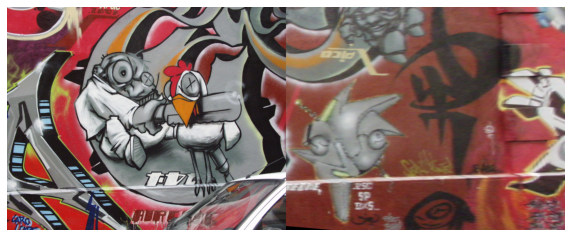

In [5]:

dst = cv.warpPerspective(img5, np.linalg.inv(finalH7), ((img5.shape[1] + img1.shape[1]), img1.shape[0]))
dst[0:img1.shape[0], 0:img1.shape[1]] = img1
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(dst)
ax.axis('off')
plt.show()

In [6]:
#
H1to5 = np.matrix([[6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
                [2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
                [4.9212545e-04,  -3.6542424e-05,   1.0000000e+00]])

diff_mat = abs(H1to5 - finalH7)
print(diff_mat)


[[6.45345924e-02 1.89582531e-02 8.12239604e+00]
 [6.64221085e-02 5.19094988e-02 2.40597120e+01]
 [1.21696273e-04 3.44992716e-05 1.05391995e-02]]


Question 1

9.60530003431819
9.65891824344015


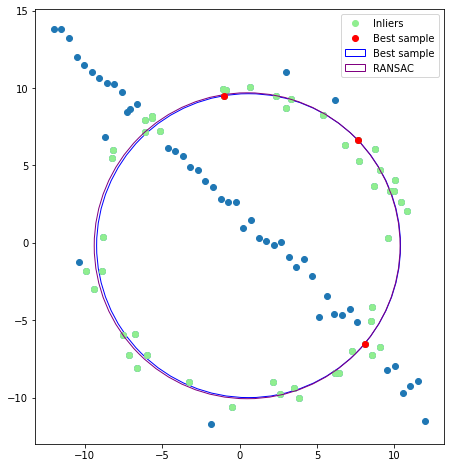

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import cv2 as cv

        
def getCircle(pts1, pts2, pts3):
    temp = pts2[0]**2 + pts2[1]**2
    bc = (pts1[0]**2 + pts1[1]**2 - temp)/2
    cd = (temp - pts3[0]**2 - pts3[1]**2)/2
    det = (pts1[0] - pts2[0]) * (pts2[1] - pts3[1]) - (pts2[0] - pts3[0]) * (pts1[1] - pts2[1])

    if abs(det) < 1.0e-10:
        return None
    cx = (bc*(pts2[1] - pts3[1]) - cd*(pts1[1] - pts2[1]))/ det
    cy = ((pts1[0] - pts2[0]) * cd - (pts2[0] - pts3[0])*bc)/ det

    r = ((cx - pts1[0])**2 + (cy - pts1[1])**2)**0.5

    return cx, cy, r

def shortest_Dis(p,centerx,centery,radius):
    d= np.array(abs(((p[:,0]-centerx)**2+(p[:,1]-centery)**2)**0.5-radius))
    return d


def RANSAC_algo(Data,iteration,threshold,no_inlier):
    maximum=0
    output=np.array([])

    for i in range(iteration):

        randomPoints=np.random.choice(Data.size//2, size=3, replace=False)
        centerx,centery,radius=getCircle(Data[randomPoints[0]],Data[randomPoints[1]],Data[randomPoints[2]])
        PO=shortest_Dis(Data,centerx,centery,radius)

        if radius>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<threshold]

        if len(inliares)>no_inlier:
               
            shrt_d=shortest_Dis(inliares,centerx,centery,radius)
            mean = sum(shrt_d/shrt_d.size)
            if maximum < len(inliares):
               
                best=mean
                output=randomPoints
                maximum=len(inliares) 
                inli=inliares
            elif maximum == len(inliares) and best>mean:
                best=mean
                output=randomPoints
                inli=inliares
    print(radius)
    return output,inli

def plotCircle(Data,Datalst,color='r'):
    centerx,centery,radius=getCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((centerx,centery),radius,fill=False)
    c.set_color(color)
    return c


#np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x +b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))



ranL,bestInlier=RANSAC_algo(X,500,1,40)         
circle1=plotCircle(ranL,X, color = 'blue')
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( circle1 )
p1=ax.scatter(X[:,0],X[:,1])
Inliers=ax.scatter(bestInlier[:,0],bestInlier[:,1], color='lightgreen' )
bestfit,inl=RANSAC_algo(bestInlier,50,1,bestInlier.size//2.2)
circle2=plotCircle(bestfit,bestInlier, color ='purple')
ax.add_artist( circle2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
Bestsamples=ax.scatter(Y[:,0],Y[:,1], c = 'r')
plt.legend(handles=[Inliers,Bestsamples,circle1,circle2],labels=['Inliers','Best sample','Best sample','RANSAC'])
plt.show()


Question 2

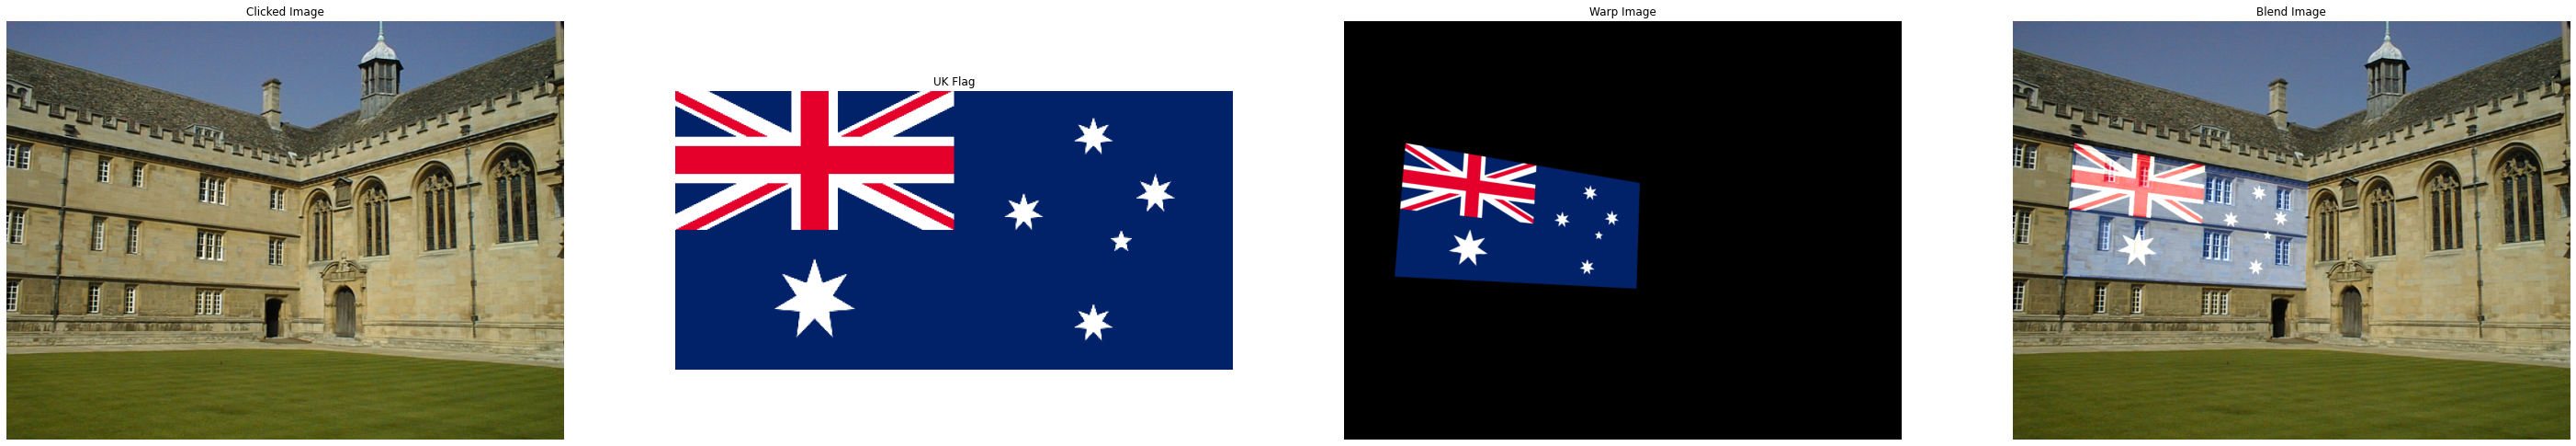

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

count = 0
points = []
width = 0
height = 0

def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None

def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2

    return width, height

img1 = cv.imread(r'C:\Users\Lahiru Sanjaya\Desktop\assignment 2\002.jpg', cv.IMREAD_COLOR)
img2 = cv.imread(r'C:\Users\Lahiru Sanjaya\Desktop\assignment 2\Flag_of_Australia_(converted).svg.png', cv.IMREAD_REDUCED_COLOR_4)
img3 = img1

cv.imshow("original image", img1)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows()

pts_src = np.array([[0,0], [img2.shape[1],0], [0, img2.shape[0]], [img2.shape[1],img2.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points)


h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
im_out = cv.warpPerspective(img2, h, (img1.shape[1], img1.shape[0]))
blend_image = cv.addWeighted(img1, 0.95, im_out, 0.8, 0.0)


fig, ax = plt.subplots(1,4, figsize = (50,10))
ax[0].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[0].set_title("Clicked Image")
ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].set_title("UK Flag")
ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(im_out, cv.COLOR_BGR2RGB))
ax[2].set_title("Warp Image")
ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB))
ax[3].set_title("Blend Image")
ax[3].axis('off')
plt.show()  




